# Let's see how our code compares to Keras in terms of speed
First we do a Keras prediction

In [11]:
#System imports
from __future__ import print_function

#External imports 
from keras import layers, models
from keras import backend as K
from matplotlib import pyplot as plt

#Local imports 
from naive_prediction.data_utils import read_keras_model_from_file
from pyopencl_prediction.pyopencl_forward_pass import predict, build_kernels
from data import generate_straight_tracks
from drawing import draw_2d_event, draw_2d_input_and_pred

#For consistent printing
import numpy as np
import pyopencl as cl
from pyopencl import array
np.set_printoptions(suppress=True)

#to test performance
import time

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#load the model
model = read_keras_model_from_file('/Users/Thomas/Desktop/opencl-cnn/model1.h5')

#test input generator
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

In [3]:
det_shape = (64, 64)
num_tracks = 16
#print("first one beginning")
keras_prediction_num_events_vs_time = ([], []) #x, y
for num_test in range(0, 101, 5):
    #print("iteration number", num_test) 
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    test_pred = model.predict(test_events)
    end = time.time()
    keras_prediction_num_events_vs_time[0].append(num_test)
    keras_prediction_num_events_vs_time[1].append(end-start)
#print("first one done")
num_test = 10
keras_prediction_num_tracks_vs_time = ([], [])
inc = 8
for i in range(1, 6):
    num_tracks = 8**i
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    test_pred = model.predict(test_events)
    end = time.time()
    keras_prediction_num_tracks_vs_time[0].append(num_tracks)
    keras_prediction_num_tracks_vs_time[1].append(end-start)
    inc = inc*8 - inc

<IPython.core.display.Javascript object>


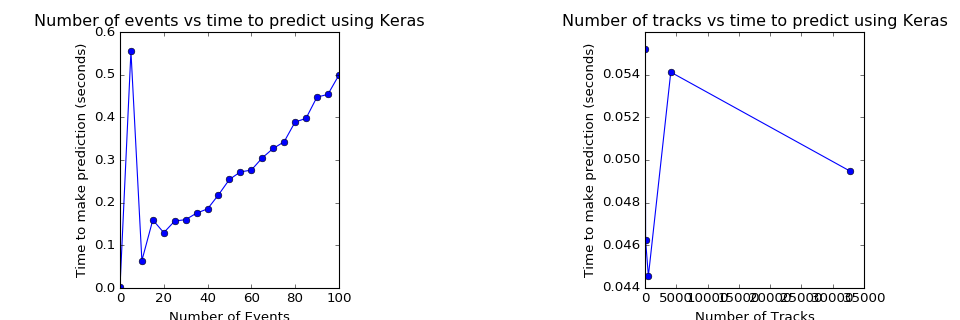

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(keras_prediction_num_events_vs_time[0], keras_prediction_num_events_vs_time[1], '-o')
plt.xlabel('Number of Events')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Number of events vs time to predict using Keras')
plt.subplot(133)
plt.plot(keras_prediction_num_tracks_vs_time[0], keras_prediction_num_tracks_vs_time[1], '-o')
plt.xlabel('Number of Tracks')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Number of tracks vs time to predict using Keras')
plt.show()

Looks like this is linear with number of tracks, I'll stick with number of events in that case. Looks like essentially linear growth for Keras. Now let's try our code! First we'll just use the standard python code.

In [27]:
platforms = cl.get_platforms()
devices = platforms[0].get_devices()
ctx = cl.Context([devices[0]])
queue = cl.CommandQueue(ctx)
prg = build_kernels(ctx)

pyopencl_prediction_num_events_vs_time = ([], []) #x, y
for num_test in range(0, 101, 5):
    if num_test == 0:
        continue
    print("iteration number", num_test) 
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    #print(test_events.shape)
    test_pred = predict(model, test_events, prg, queue)
    end = time.time()
    pyopencl_prediction_num_events_vs_time[0].append(num_test)
    pyopencl_prediction_num_events_vs_time[1].append(end-start)

iteration number 5
(64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 16, 16, 8)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 16, 16, 16)
(1, 32, 32, 16)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 1)
(64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 16, 16, 8)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 16, 16, 16)
(1, 32, 32, 16)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 1)
(64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 16, 16, 8)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 16, 16, 16)
(1, 32, 32, 16)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 1)
(64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 16, 16, 8)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 8, 8, 16)
(1, 16, 16, 16)
(1, 32, 32, 16)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 8)
(1, 64, 64, 1)
(64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 8)
(1, 32, 32, 8)
(1, 16, 16, 8)
(1, 8, 8, 16)
(1, 8, 8, 16)
(

<IPython.core.display.Javascript object>


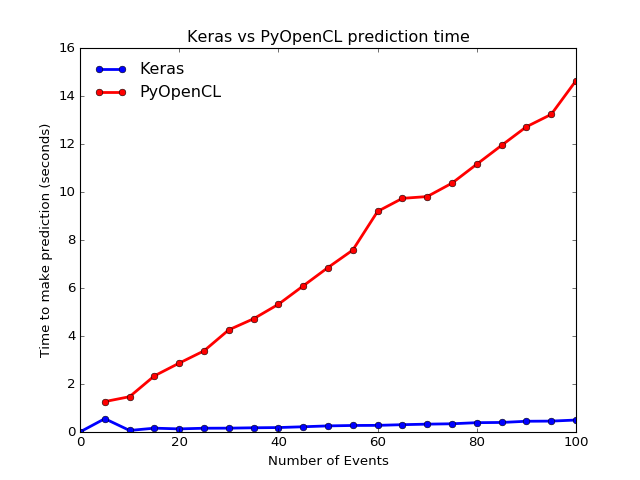

In [28]:
plt.plot(keras_prediction_num_events_vs_time[0], keras_prediction_num_events_vs_time[1], '-o', color="blue", linewidth=2.5, linestyle="-", label="Keras")
plt.plot(pyopencl_prediction_num_events_vs_time[0], pyopencl_prediction_num_events_vs_time[1], '-o', color="red", linewidth=2.5, linestyle="-", label="PyOpenCL")
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Number of Events')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Keras vs PyOpenCL prediction time')
plt.show()